# Using NLTK to predict news authorship

### Background and motivation
A week ago I came across a data science challenge as part of an internship application. I have finally started a concerted effort to learn python, this challenge offered a nice opportunity to test my progress thus far. The prompt is __[here](https://www.glassdoor.com/Job/rowayton-ct-quantitative-analyst-intern-jobs-SRCH_IL.0,11_IC3793531_KO12,39.htm?src=GD_JOB_AD&t=EMPLOYER_SEARCH_RESULTS&ao=4011&s=21&rdserp=true&srs=EI_JOBS&jl=3036917810)__ if you're interested. The challenge was split into two parts. Part 1 entailed taking a dataset from __[kaggle](https://www.kaggle.com/rmisra/news-category-dataset)__ and writing a function to clean and process the raw text data, then generate unigrams and bigrams for output into an excel file. Part 2 was open ended, but it was clear they were interested in seeing some NLP and ML work. 

It has been a while since I've done any type of modeling or data munging, and it's the first time I've completed any analysis in python. I'm sure I'll look back at this and cringe at parts of this, but in the spirit of sharing and receiving feedback, I'm putting it up!

I had 3 things I wanted to demonstrate as part of performing this challenge.

1. I know enough (can learn fast enough) Python to be dangerous. 
2. I understand the (simplified) ML workflow.
3. I seek complete understanding of how ML / statistical learning methods work (get under the hood).

I enjoy figuring out the details of how data science packages actually work, as opposed to following a 'cookbook' approach. I find that once you develop a solid understand of what it actually does with the data, you find yourself thinking of more creative ways of applying it to your problem. Additionally, you stand a better chance of interpreting and effectively communicating results to your audience.

That being said, I have a LOT to unpack with respect to various statistical/machine learning methods. For this challenge I limited myself to peeling back the specifics of what exactly this TF-IDF method was in NLTK. I spent a fair amount of time reading about how TFIDF is calculated and thinking about what it means in different contexts. Once I had a solid grasp of TFIDF, I realized that grouping all of the news articles by author, a TFIDF transformation could be used to extract the most distinct words to that specific author, relative to the others.

My hypothesis was that these words, that perhaps are a better representation of an authors style, would do a better job at identifying the author of previously unseen news articles compared to using a simpler method such as most common words.

### A quick primer on tf_idf <a name="part1"></a>

There are a lot of great explanations on this concept, even an entire __[site](http://www.tfidf.com/)__ to discuss the technique. I'll provide a brief overview for completeness.

TFIDF stands for "Term Frequency - Inverse Document Frequency". A mouthful, but essentially it is a transformation from a set of documents to a set of term weight vectors. A more concrete example; the domain could be a column of strings in a dataframe, and the TFIDF would be a matrix, where each column corresponds to a word that appears in the entire collection of documents (i.e. any of the strings in the column) and each row corresponds to an entry in the column. The values at an index $(i,j)$ are weights, represented as floats, that indicate how important word $i$ is in document $j$.

The interesting part is how the weight is actually calculated. It is the product of two values, term frequency $tf(t,d)$ and inverse document frequency $idf(t,D)$. The term frequency can be thought of as the 'local' part, this is calculated for the term, document combination. The inverse document frequency is the 'global' part, this is calculated for all terms across the entire collection of documents.

$$tf(t,d): \text{frequency of term t in document d}$$ 

$$idf(t,D): log\Bigg(\frac{\text{number of documents}}{\text{number of documents that contain term t}}\Bigg)$$

The $tf(t,d)$ places greater weight on the terms that appear most often, however $idf(t,D)$ will adjust that weight based on how *common* the word is across the collection of documents. If all the documents in the collection contain a word, then the $idf$ is zero ( $log(1)$). As words become more unique, relative to other documents, their weighting increases.

It is important to note that there are various ways to calculate TF-IDF. Some implementations will use base 2 logarithm, whereas others will use natural base as a default. If you browse wikipedia, you'll see quite a few other variations. 

For my purposes, I used the default settings from the `gensim` package. This is because I was trying to find the most distinct words to each author. For the most part, changing the log base will only change the weighting, but should not change the order of the words.

Now on to the analysis!


# Table of contents
1. [Part 1: N-Grams to Excel](#part1)
2. [Part 2: K-Fold CV and Naive Bayes to Predict Authors of Future Articles](#part2)
    1. [Simple exploration](#part2-1)
    2. [Prepare data, test and training](#part2-2)
    3. [Data structuring and functions for featureset building](#part2-3)
    4. [CV and model specifications](#part2-4)
    5. [K-Fold Cross Validation](#part2-5)
    6. [Evaluation on Test Data](#part2-6)
    7. [Final Comments](#part2-7)

## Part 1: N-Grams to Excel <a name="part1"></a>
This section just shows how I performed some of the data cleaning tasks, which included creating some functions that concatenate the string columns of interest, strip punctuation, tokenize, stem and lemmatize, create a text corpus (which makes it easier to perform some of the transformations) and outputs some bigrams to excel (this was part of the cahllenge)


In [1]:
%matplotlib inline
import nltk
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import openpyxl
import re
import matplotlib
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
from nltk.stem.porter import *
from nltk.corpus import stopwords
from collections import Counter
import gensim
from gensim import corpora, models
import datetime

In [2]:
# load dataset
data_df = pd.read_json('News_Category_Dataset_v2.json', lines=True)

In [3]:
data_sample = data_df.sample(n = 10000)
data_sample.reset_index(drop=True, inplace=True)

In [4]:
# data processing function
def process_raw(df, headline, description):
    """
    - concatenate headline w/ short_description. format as sentences
    - for each row, tokenize, lemmatize, text corpus and create words
    """
    # make headline a sentence
    df["headline_sent"] = df[headline].map(lambda x: (str(x) + ".") if len(str(x))>0 and str(x)[-1] != "." else str(x))
    # concatenate headline and description
    df["concat"] = df["headline_sent"].map(str) + " " + df[description].map(str)
    # strip punctuation
    df["concat_nopunct"] = df["concat"].apply(lambda x: re.sub(r'[^\w\s]','',x))
    # tokenize
    df["tokens"] = df['concat_nopunct'].map(nltk.word_tokenize)
    # remove stopwords
    df['tokens_filtered'] = df["tokens"].apply(lambda row:[w.lower() for w in row if not w.lower() in stopwords.words('english')])
    # stem
    stemmer = PorterStemmer()
    df["stemmed_tokens"] = df["tokens_filtered"].apply(lambda row: [stemmer.stem(token) for token in row])
    # lemmatize
    wnl = nltk.WordNetLemmatizer()
    df['lemma'] = df['stemmed_tokens'].apply(lambda row: [wnl.lemmatize(token) for token in row])
    # create text corpus
    df["text_corpus"] = df["tokens"].map(nltk.Text)
    # create words
    df["words"] = df["text_corpus"].apply(lambda x: [word.lower() for word in x])
    return df

In [5]:
def grams_to_excel(df, headline, description):
    # create bigrams from lemma
    processed_data = process_raw(df, headline, description)
    processed_data['bigrams'] = processed_data["lemma"].apply(lambda x: [' '.join(lem) for lem in nltk.ngrams(x, 2)])
    
    # frequency counts of uni and bi grams
    funigrams = nltk.FreqDist([item for sublist in processed_data['lemma'] for item in sublist])
    funigrams_df = pd.DataFrame.from_dict(funigrams, orient='index').reset_index()
    fbigrams = nltk.FreqDist([item for sublist in processed_data['bigrams'] for item in sublist])
    fbigrams_df = pd.DataFrame.from_dict(fbigrams, orient='index').reset_index()
    
    funigrams_df.columns = ("unigram", "count")
    fbigrams_df.columns = ("bigram", "count")
    
    funigrams_df.sort_values("count", inplace=True, ascending=False)
    fbigrams_df.sort_values("count", inplace=True, ascending=False)

    #write to file
    writer = pd.ExcelWriter('ngram_output.xlsx')
    funigrams_df.to_excel(writer,'lemma')
    fbigrams_df.to_excel(writer,'bigrams')
    writer.save()
    return funigrams_df, fbigrams_df



In [6]:
uni_df, bi_df = grams_to_excel(data_sample, "headline", "short_description")

## Part 2: K-Fold CV and Naive Bayes to Predict Authors of Future Articles <a name="part2"></a>

This section demonstrates how TF_IDF can be used to extract unique words for an author, compared to using a simpler approach, such as FrequencyDistribution. We apply both techniques and inspect a few authors for comparison.

This the motivates our modeling example, using the term features identified to classify the author of the news article, and for previously unseen (i.e. articles in the future).

We will compare three groups of models; first will use top words from FrequencyDistribution transformation, the second will use the TF-IDF transformation and the third will take the union of the first two. This will demonstrate how the features identified using a TFIDF transformation will outperform features identified in a FrequencyDistribution transformation. Additionally, each group of models contains 5 models that increase in flexibility (i.e. number of features, or top words). This is to illustrate the variance-flexibility tradeoff. This will all be done with a simple naive bayes classifier and a 10-fold cross validation.

For the sake of the example, we restrict our world to the Politics news category, and only the top 10 authors by volume over the dataset


In [7]:
# focus on politics, top 10 authors
politics = data_df[data_df["category"] == "POLITICS"]
top10authors = politics["authors"].value_counts()[1:10]
politicstop10auth = politics[politics["authors"].isin(top10authors.index)].reset_index()
result = process_raw(politicstop10auth, "headline", "short_description")

### Part 2.1: Simple exploration <a name="part2-1"></a>

We start with some simple FreqDist and TFIDF to motivate the use of choosing words by frequency and choosing words by tfidf as features within the classification model

- restrict to politics news, top 10 authors
- calculate top 10 words by freqdist for 3 authors
- calculate top 10 words by tfidf importance for 3 authors
- compare the results

In [8]:
# Generate Frequency Distributions
result["lemma_fd"] = result["lemma"].apply(lambda x: nltk.FreqDist(x))
result["words_fd"] = result["words"].apply(lambda x: nltk.FreqDist(x))

In [9]:
# Sum Frequency Distributions by Category
grouped_result = result.groupby(["authors"])["lemma_fd"].apply(lambda x: [entry for entry in x]).reset_index()
grouped_result["combined_fd"] = grouped_result["lemma_fd"].apply(lambda x: sum(x, Counter()))

In [10]:
# calculates top10 words by FreqDist for author
def freqdist_author(df, author):
    '''
    prepares author dataframes for plotting 
    '''
    auth_top10dict = dict(df[df["authors"] == author]["combined_fd"].iloc[0].most_common(10))
    auth_top10 = pd.DataFrame.from_dict(auth_top10dict, orient='index')
    auth_top10["word"] = auth_top10.index
    auth_top10.reset_index(drop=True, inplace=True)
    auth_top10.columns = ("count", "word")
    auth_top10.sort_values('count', ascending=False, inplace=True)
    return auth_top10
    

In [11]:
# dictionary from lemma series
dictionary = gensim.corpora.Dictionary(result["lemma"])
# filter the dictionary
dictionary.filter_extremes(no_below=5, no_above=0.8, keep_n=100000)

In [12]:
# group df by category, generate bow_corpus on category
grouped_result_tfidf = result.groupby(["authors"]).agg({"lemma": 'sum'})
# generate bag of words corpus
grouped_result_tfidf["bow_corpus"] = grouped_result_tfidf["lemma"].map(dictionary.doc2bow)
# generate tfidf model on bag of words corpus
tfidf = models.TfidfModel(grouped_result_tfidf["bow_corpus"])
# apply the tfidf model to each bow_corpus
grouped_result_tfidf["corpus_tfidf"] = grouped_result_tfidf["bow_corpus"].apply(lambda x: tfidf[x])

In [13]:
def tfidf_author(df, author):
    '''
    generates the top10 words by tfidf within a category, returns a dataframe
    '''
    auth_tfidf = pd.DataFrame(df.loc[author, "corpus_tfidf"], columns = ("Index", 'TFIDF'))
    auth_tfidf.sort_values('TFIDF', ascending=False, inplace=True)
    auth_tfidf.reset_index(drop=True, inplace=True)
    auth_tfidf.drop(auth_tfidf.index[10:], inplace=True)
    auth_tfidf['word'] = auth_tfidf['Index'].apply(lambda x: dictionary[x])
    return auth_tfidf

**Compare top 10 words by FreqDist to TFIDF and plot for 3 authors**
- plot results against each other to compare difference in selection

Text(0.06, 0.66, 'FreqDist')

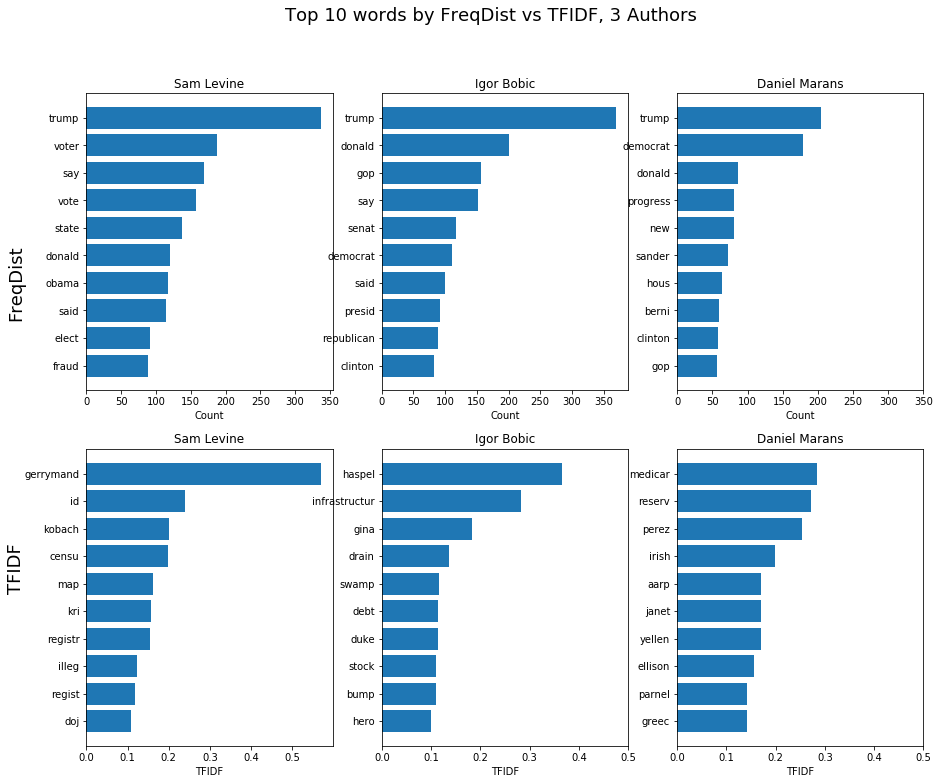

In [14]:
top_3 = [tfidf_author(grouped_result_tfidf, auth) for auth in top10authors.index[0:3]]
top_3_fd = [freqdist_author(grouped_result, auth) for auth in top10authors.index[0:3]]

fig = plt.figure(figsize=(15,12))

# author 1
ax1 = fig.add_subplot(231)
ax1.set_xlabel('Count')
ax1.set_title(top10authors.index[0])
plt.barh(top_3_fd[0]["word"], top_3_fd[0]["count"])
ax1.invert_yaxis()
ax1.set_xticks(np.arange(0,351,50))

# author 2
ax2 = fig.add_subplot(232)
ax2.set_xlabel('Count')
ax2.set_title(top10authors.index[1])
plt.barh(top_3_fd[1]["word"], top_3_fd[1]["count"])
ax2.invert_yaxis()
ax2.set_xticks(np.arange(0,351,50))

# author 3
ax3=fig.add_subplot(233)
ax3.set_xlabel('Count')
ax3.set_title(top10authors.index[2])
plt.barh(top_3_fd[2]["word"], top_3_fd[2]["count"])
ax3.invert_yaxis()
ax3.set_xticks(np.arange(0,351,50))

#author1
ax1 = fig.add_subplot(234)
ax1.set_xlabel('TFIDF')
ax1.set_title(top10authors.index[0])
plt.barh(top_3[0]["word"], top_3[0]["TFIDF"])
ax1.invert_yaxis()
ax1.set_xticks(np.arange(0,.51,.1))
#author2
ax2 = fig.add_subplot(235)
ax2.set_xlabel('TFIDF')
ax2.set_title(top10authors.index[1])
plt.barh(top_3[1]["word"], top_3[1]["TFIDF"])
ax2.invert_yaxis()
ax2.set_xticks(np.arange(0,.51,.1))

#author3
ax3=fig.add_subplot(236)
ax3.set_xlabel('TFIDF')
ax3.set_title(top10authors.index[2])
plt.barh(top_3[2]["word"], top_3[2]["TFIDF"])
ax3.invert_yaxis()
ax3.set_xticks(np.arange(0,.51,.1))

plt.suptitle("Top 10 words by FreqDist vs TFIDF, 3 Authors", size=18)

fig.text(0.06, 0.33, 'TFIDF', ha='center', va='center', rotation='vertical', size=18)
fig.text(0.06, 0.66, 'FreqDist', ha='center', va='center', rotation='vertical', size=18)

This plot shows most important words for 3 authors, identified using two approaches. The first column are the words identified using FrequencyDistribution. This means that these words are simply the most common words for that author. Interesting (or perhaps not) 'trump' is the most common word across all 3 authors. We see a few other words that are common to all 3. These words would probably not be useful features in a classifier.

The second row shows important words for the same 3 authors, identified using the TF-IDF transformation. These words are the most distinct words for that author, compared to their cohort. We can see that the TFIDF approach gives us a greater differentiation in words to consider. No word appears twice across these 3 authors. 

We might conjecture that Daniel Marans writes primarily about left issues ("medicar", "aarp", "berni", "democrat") where as Igor Bobic might be more right leaning ("infrastructure", "debt", "swamp", "republican", "gop"). This suggests that these words would be more helpful in building a classification model.


### Part 2.2: Prepare data, test and training <a name="part2-2"></a>

For our simplified modeling example, we'll split the dataset into a training and testing set. Since the records are sorted by date, the testing set will represent news articles in the future. This means there could be topics, and therefore words, that are in the testing dataset that the model did not previously learn. Let's see how well this approach works.

- load processed dataset and filter to politics, filter to top 10 authors by volume
- split into training and test data (first 3000 records are training data)

In [15]:
from ast import literal_eval
from sklearn.model_selection import KFold

In [16]:
df = pd.read_csv("./result_processed",converters={"lemma": literal_eval})

In [17]:
politics = df.loc[df.category == "POLITICS"]
top10authors = politics["authors"].value_counts()[1:10]
politicstop10auth = politics[politics["authors"].isin(top10authors.index)].reset_index()

In [18]:
# these are the top ten authors
top10authors.index

Index(['Igor Bobic', 'Daniel Marans', 'Marina Fang', 'Paige Lavender',
       'Amanda Terkel', 'Mary Papenfuss', 'Mollie Reilly',
       'Ariel Edwards-Levy', 'Lauren Weber'],
      dtype='object')

In [19]:
# split into training data and test data
train = politicstop10auth.loc[0:3000,]
test = politicstop10auth.loc[3001:,]

### Part 2.3: Data structuring and functions for featureset building <a name="part2-3"></a>
Some more code where we create some of the parameters for model generation, and wrap much of the processing into some functions
- build and filter dictionary from training dataset
- group df by authors and build author specific bow and tfidf corpus
- define functions that specify the model
    - create top n words by tfidf and bow techniques, add to training as columns
    - generate featureset for each record of training


In [20]:
# dictionary from lemma series
auth_dict = gensim.corpora.Dictionary(train["lemma"])

# filter the dictionary - this is arbitrary
auth_dict.filter_extremes(no_below=5, no_above=0.8, keep_n=100000)

# group by author to find the 'distinctly this author' words
auth_grp = train.groupby(["authors"]).agg({"lemma": 'sum'})

# bow, tfidf model and corpus
auth_grp["bow_corpus"] = auth_grp["lemma"].map(auth_dict.doc2bow)
tfidf = models.TfidfModel(auth_grp["bow_corpus"])
auth_grp["corpus_tfidf"] = auth_grp["bow_corpus"].apply(lambda x: tfidf[x])

In [21]:
def tfidf_author(df, author, word_dict, n):
    '''
    generates the top n words by tfidf within an author (category), returns a dataframe
    '''
    auth_tfidf = pd.DataFrame(df.loc[author, "corpus_tfidf"], columns = ("Index", 'TFIDF'))
    auth_tfidf.sort_values('TFIDF', ascending=False, inplace=True)
    auth_tfidf.reset_index(drop=True, inplace=True)
    auth_tfidf.drop(auth_tfidf.index[n:], inplace=True)
    auth_tfidf['word'] = auth_tfidf['Index'].apply(lambda x: word_dict[x])
    return auth_tfidf

def bow_author(df, author, word_dict, n):
    '''
    generates the top n words by tfidf within an author, returns a dataframe
    '''
    auth_bow = pd.DataFrame(df.loc[author, "bow_corpus"], columns = ("Index", 'Count'))
    auth_bow.sort_values('Count', ascending=False, inplace=True)
    auth_bow.reset_index(drop=True, inplace=True)
    auth_bow.drop(auth_bow.index[n:], inplace=True)
    auth_bow['word'] = auth_bow['Index'].apply(lambda x: word_dict[x])
    return auth_bow

From here down are the model specifications

In [22]:
# generate distinct author words
def generate_all_words(list_authors, df_auth, word_dict, n_tf, n_bow):
    '''
    Quick function, requires dataframes already named and built
    '''
    distinct = []
    for auth in list_authors:
        distinct += tfidf_author(df_auth, auth, word_dict, n_tf).word.tolist()

    # generate top n words for each author
    freq = []
    for auth in list_authors:
        freq += bow_author(df_auth, auth, word_dict, n_bow).word.tolist()

    all_words = set(distinct + freq)
    return all_words

In [23]:
# generate features for dataset
def author_features(document_lemmas, all_words):
    features={}
    # check if each lemma is part of the all words
    for word in all_words:
        features['contains({})'.format(word)] = (word in document_lemmas)
    return features


### Part 2.4: Model and CV specification <a name="part2-4"></a>
In this section, we create the models and their parameters to run. You'll notice that the models are stored in a dictionary, where each entry represents the group of models, and the value is another dictionary of models with their parameter specifications. Each group of models increases in flexibility; tfidf_only starts with 5 of the top words, selected by TFIDF and no words by FreqDist, fredist_only group is the opposite and tfidf_and_freqdist combines the two.

- define models with increasing flexibility
- define number of folds for CV

I chose an arbitrary number of models and model flexiblity. The point here is that as we add more 'top words' to the feature set, we begin risking overfitting the data. A K-Fold CV will help point to an acceptable level of flexiblity.

In [41]:
# define the models and their parameters 
auth_models = {'tfidf_only':{'model_1':(10,0), 'model_2':(20,0), 'model_3':(50,0), 'model_4':(100,0), 'model_5':(200,0)},
              'freqdist_only':{'model_6':(0,10), 'model_7':(0,20), 'model_8':(0,50), 'model_9':(0,100), 'model_10':(0,200)},
               'tfidf_and_freqdist':{'model_11':(10,10), 'model_12':(20,20), 'model_13':(50,50), 'model_14':(100,100), 
                                     'model_15':(200,200)}}
# number of folds in kfolds cross validation
n_folds = 10

model_keys = []
for k, v in auth_models.items():
    model_keys.append([(x,y) for x,y in zip(len(v.keys())*[k], list(v.keys()))])
model_keys = [key for sublist in model_keys for key in sublist]

results_matrix = pd.DataFrame(model_keys, columns = ["group","models"])
results_matrix = results_matrix.reindex(columns = results_matrix.columns.tolist() + \
                                        ['fold: ' + str(x) for x in list(range(1, n_folds+1))])


### Part 2.5: Run KFold CV <a name="part2-5"></a>
Here is where we run the KFold simulation and interpret the results

In [42]:
for gp, model_set in auth_models.items():
    for mod, params in model_set.items():
        # define the parameters for the feature set of the model
        all_words = generate_all_words(top10authors.index, auth_grp, auth_dict, params[0], params[1])
        author_feats = train.lemma.apply(lambda x: author_features(x, all_words))
        featureset = [(x,y) for x,y in zip(author_feats, train["authors"])]

        kf = KFold(n_splits=n_folds, shuffle=True)

        print('running:{}'.format(mod)) # to print output for updates
        i = 1 # to help set values in result matrix

        # KF splits the featureset into n folds, performs the classification and then evaluates accuracy
        for train_index, test_index in kf.split(featureset):
            train_set = [featureset[x] for x in train_index]
            test_set = [featureset[x] for x in test_index]
            classifier = nltk.NaiveBayesClassifier.train(train_set)
    #         print('accuracy:{}'.format(nltk.classify.util.accuracy(classifier,test_set)))
            
            results_matrix.loc[results_matrix.models == mod,"fold: " + str(i)] = nltk.classify.util.accuracy(classifier, test_set)
            i += 1

running:model_1
running:model_2
running:model_3
running:model_4
running:model_5
running:model_6
running:model_7
running:model_8
running:model_9
running:model_10
running:model_11
running:model_12
running:model_13
running:model_14
running:model_15


Text(0.5, 0.98, 'Accuracy vs Model Flexiblity, 10-Fold Cross Validation')

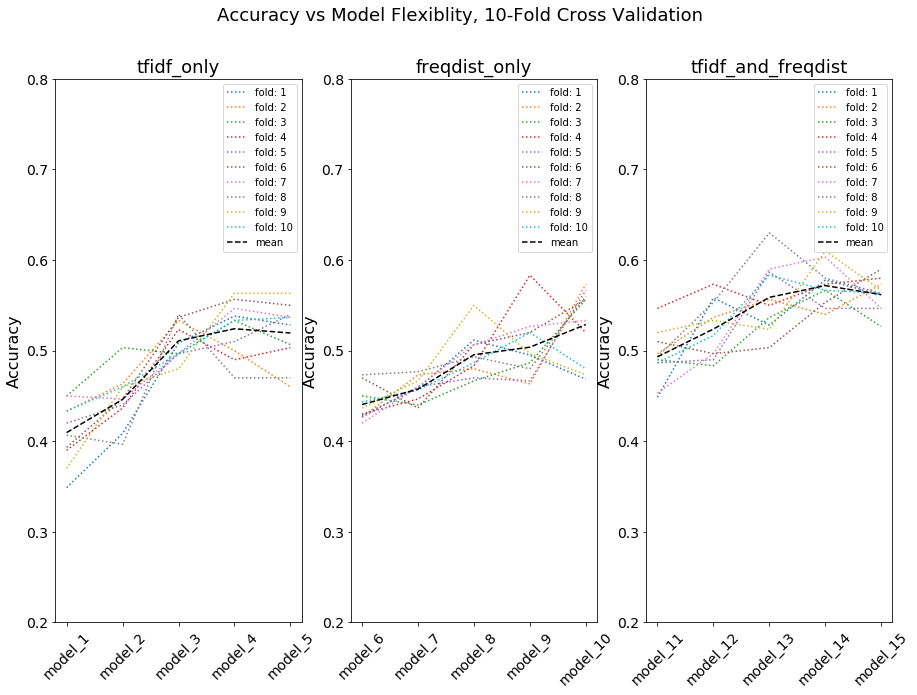

In [43]:
results_matrix["average"] = results_matrix.iloc[:,1:].mean(axis=1)
mod_group = results_matrix["group"].unique()
fig, axs = plt.subplots(1,3, figsize=(15,10))
plt.subplots_adjust(hspace=.25)
for ax, mod_group in zip(axs.ravel(), mod_group):
    data = results_matrix.loc[results_matrix["group"] == mod_group,:]
    for i in range(1, n_folds+1): 
        ax.plot(data.loc[:,"models"], data.loc[:,"fold: " + str(i)], \
                linestyle=":", label = "fold: " + str(i))

    ax.plot(data.loc[:,"models"], data.loc[:,"average"],color = 'black', linestyle="--", label="mean")

#     # Shrink current axis by 20%
#     box = ax.get_position()
#     ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])

    # Put a legend to the right of the current axis
    #ax.legend()
    ax.legend(loc='upper right')
    ax.set_yticks(list(np.arange(.2,.8,.1)))
    ax.set_yticklabels(labels = [round(x,1) for x in np.arange(.2,.8,.1)], size=14)
    ax.set_xticklabels(data["models"], size=14, rotation = 45)
    ax.set_ylabel("Accuracy", size=16)
#    ax.set_xlabel("Accuracy", size=16)
    ax.set_title(mod_group, size =18)
fig.suptitle("Accuracy vs Model Flexiblity, 10-Fold Cross Validation", size =18)

This figure compares the 3 groups of models, showing their accuracy changes with increasing model flexibility. The y-axis is our accuracy metric (the number of documents correctly classified) and the x-axis shows the models, arranged by increasing flexibility.

Each colored/dotted line represents a 'fold' or a run of model training and accuracy assessment. This helps us to visualize the variability of each model. The black dotted line is the average accuracy score across the K folds for the model, this shows us the overall trend of accuracy vs increased flexibility.

 We can see that after model 4, for the combined model, the accuracy does not improve. Additionally, we see variation across the K-Folds within each of the models, which means that NaiveBayes may not be the best approach to represent the data, or their is irreducible error in the data

### Part 2.6: Final results on test data <a name="part2-6"></a>

Finally, we'll select a model and perform the final test. Inspecting the previous chart, it appears the cutoff point is model_4 with respect to the flexiblity

- define model parameters
- run model, check accuracy and confusion matrix

In [44]:
# define the parameters for the feature set
all_words = generate_all_words(top10authors.index, auth_grp, auth_dict, 100, 100)
author_feats_test = test.lemma.apply(lambda x: author_features(x, all_words))
featureset_test = [(x,y) for x,y in zip(author_feats_test, test["authors"])]

classifier = nltk.NaiveBayesClassifier.train(featureset_test)

In [45]:
from nltk.metrics import scores as nltk_scores
predicted = [classifier.classify_many([x[0]])[0] for x in featureset_test]
actual = [x[1] for x in featureset_test]
cm = nltk.ConfusionMatrix(predicted, actual)
print("Accuracy on Test Set: {}".format(round(nltk_scores.accuracy(predicted, actual),2)))

Accuracy on Test Set: 0.66


### Closing Summary <a name="part2-7"></a>

In summary, we found that a NaiveBayes classifier, using a featureset built off of the top words for each author (selected by FreqDist and TFIDF) performs quite well. ~ 66% of the 'future' observations were correctly classified. 

Further iterations, where we work to find a more granular level of optimal features might lend improvement to the classifier. Another interesting approach could be to incorporate sentiment scores, bigrams, tri-grams and part of speech tagging. These additional components could help us extract more features that better represent the authors writing style, as opposed to just frequent words/topics.

Did you find this analysis interesting? Are there bits of code that don't make sense or you see a way to improve the flow (I'm 100% there is a lot of low-hanging fruit in this one)? Let me know in the comments below!